We would like to estimate the number of unique objects sampled ($K$) as a function of the number of samples ($n$), when sampling from a generator that can produce $G$ total unique objects. The sample size $n$ is very small compared to $G$.

Let $p_j$ be the probability of generating the $j$-th unique object in a single sample, for $j=1, \dots, G$. The number of unique objects sampled in $n$ trials, let's call it $K_n$, is a random variable. Typically, when asked for "the function describing the number," one refers to the expected value of this random variable, $E[K_n]$.

We can find $E[K_n]$ using indicator variables. Let $I_j$ be an indicator variable such that $I_j=1$ if the $j$-th object is sampled at least once in $n$ trials, and $I_j=0$ otherwise.
The total number of unique objects sampled is $K_n = \sum_{j=1}^{G} I_j$. By linearity of expectation, $E[K_n] = \sum_{j=1}^{G} E[I_j]$.
The expectation of an indicator variable is the probability of the event it indicates: $E[I_j] = P(I_j=1)$.
$P(I_j=1)$ is the probability that object $j$ is sampled at least once. This is equal to $1 - P(\text{object } j \text{ is never sampled in } n \text{ trials})$.
The probability of sampling object $j$ in one trial is $p_j$. So, the probability of *not* sampling object $j$ in one trial is $(1-p_j)$.
Since the samples are independent, the probability of not sampling object $j$ in $n$ trials is $(1-p_j)^n$.
Therefore, $P(I_j=1) = 1 - (1-p_j)^n$.

Substituting this back, the function describing the expected number of unique objects sampled, $U(n) = E[K_n]$, is:
$$U(n) = \sum_{j=1}^{G} \left(1 - (1-p_j)^n\right)$$

This is the exact function for the expected number of unique objects. The probabilities $p_j$ are specific to the generator and its probability distribution.

To have a better understanding of the distribution of $p_j$ we can compute the MLE for the probability of *observed* object $j$ as:
    $$\hat{p}_j = \frac{c_j}{n}$$


Since the sample size $n$ is much smaller than the total number of unique objects $G$ that the generator can produce, many (if not most) possible unique objects likely did not appear in your sample.

* For any object $j$ that was *not* observed, its count $c_j$ is 0.
* The MLE for these unobserved objects is $\hat{p}_j = 0/n = 0$.

This is a major limitation if you want to estimate the full probability distribution over all $G$ objects. Assigning a zero probability to unobserved items is inaccurate, especially when we know they *could* occur (i.e., their true $p_j > 0$, albeit small). The true underlying exponential distribution implies that many objects have small, non-zero probabilities.


In [71]:
#|code-fold: true
from dgrec.utils import parse_genotypes, str_to_mut
from dgrec.example_data import get_example_data_dir
from Bio import SeqIO
import os
import numpy as np
import matplotlib.pyplot as plt

#Importing a list of genotypes with the number of molecules detected for each genotype
data_path=get_example_data_dir()
gen_list=parse_genotypes(os.path.join(data_path,"sacB_genotypes.csv"))

gen_list[0:50:5]

[('', 42572),
 ('A76G', 112),
 ('T67G', 67),
 ('T90G', 41),
 ('A76G,A91G', 29),
 ('A72G,A79T', 22),
 ('A72G,A79G', 20),
 ('A111G', 17),
 ('A79T,A91T', 15),
 ('A79C,A91G', 13)]


Optimal breakpoint (j_min_rank): 82
Fitted alpha for the tail: 0.618
Minimum KS statistic (D): 0.0513


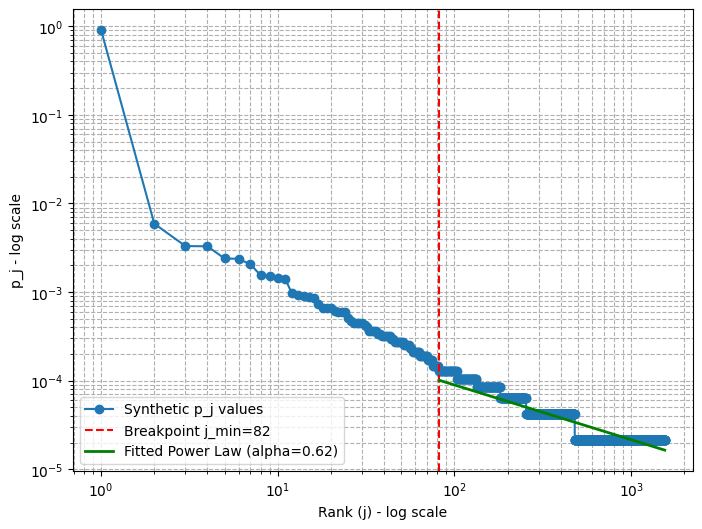

In [72]:
from dgrec.analysis import find_power_law_breakpoint_KS
from scipy.stats import linregress

counts=np.array([c for g,c in gen_list])
n=counts.sum()
pj_hat=counts/n

ranks=np.arange(1,len(pj_hat)+1)

best_j_min, best_alpha, min_D = find_power_law_breakpoint_KS(pj_hat, min_tail_size=20, alpha_threshold=0.5, verbose=False)
plt.figure(figsize=(8, 6))
plt.loglog(ranks, pj_hat, 'o-', label='Synthetic p_j values')
plt.xlabel('Rank (j) - log scale')
plt.ylabel('p_j - log scale')
plt.grid(True, which="both", ls="--")

print(f"\nOptimal breakpoint (j_min_rank): {best_j_min}")
print(f"Fitted alpha for the tail: {best_alpha:.3f}")
print(f"Minimum KS statistic (D): {min_D:.4f}")

# Add breakpoint to plot
plt.axvline(best_j_min, color='r', linestyle='--', label=f'Breakpoint j_min={best_j_min}')
log_ranks_tail = np.log(ranks[best_j_min-1:])

# Re-fit to the chosen tail to get intercept for plotting the line
if len(log_ranks_tail) >=2 :
    log_p_j_tail = np.log(pj_hat[best_j_min-1:])
    slope_final, intercept_final, _, _, _ = linregress(log_ranks_tail, log_p_j_tail)
    alpha_final = -slope_final
    C_final = np.exp(intercept_final)
    
    fitted_line = C_final * (ranks[best_j_min-1:]**(-alpha_final))
    plt.loglog(ranks[best_j_min-1:], fitted_line, 'g-', linewidth=2, label=f'Fitted Power Law (alpha={alpha_final:.2f})')
plt.legend()
plt.show()

In [73]:
from dgrec.analysis import estimate_library_size
estimate_library_size(counts, 10**9, 4**16)

44877711.70569844

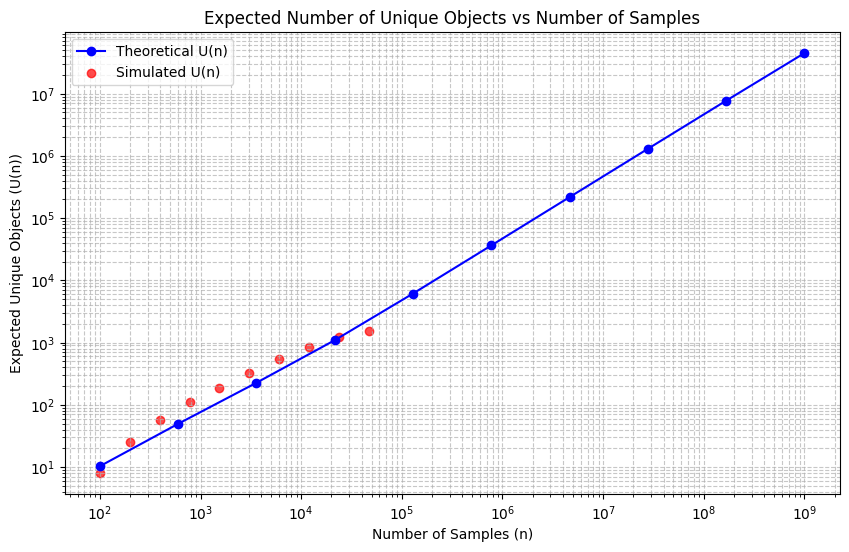

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random

# Define the range of n values (logarithmic scale)
n_values = np.logspace(2, 9, num=10, base=10, dtype=int)

# Calculate U(n) for each n (theoretical)
u_n_values = []
for n_target in n_values:
    u_n = estimate_library_size(counts, n_target, 4**16)
    u_n_values.append(u_n)

# Simulate U(n) using random sampling
simulated_u_n_values = []
genotypes = [g for g, c in gen_list]
weights = counts
n_values_sim = np.logspace(2, np.log10(sum(weights)), num=10, base=10, dtype=int)

population = [genotype for genotype, count in zip(genotypes, weights) for _ in range(count)]
all_sampled = set()
for n_target in n_values_sim:
    if n_target > len(population):
        break  # Stop if n_target exceeds the population size
    sampled_genotypes = random.sample(population, n_target)  # Sample without replacement
    all_sampled = all_sampled.union(sampled_genotypes)
    unique_genotypes = len(all_sampled)
    simulated_u_n_values.append(unique_genotypes)
    

# Plot U(n) vs n
plt.figure(figsize=(10, 6))
plt.plot(n_values, u_n_values, marker='o', linestyle='-', color='b', label='Theoretical U(n)')
plt.scatter(n_values_sim, simulated_u_n_values, color='r', label='Simulated U(n)', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Samples (n)')
plt.ylabel('Expected Unique Objects (U(n))')
plt.title('Expected Number of Unique Objects vs Number of Samples')
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.legend()
plt.show()

The observation that $U(n)$ follows a straight line when plotted against $n$ on a log-log scale, given an underlying power-law distribution for $p_j$, can  be inferred analytically, especially in certain regimes of the power-law exponent $\alpha$.

Here's a simplified analytical argument:

1.  **Setup:**
    * The expected number of unique items is $U(n) = \sum_{j=1}^{G} (1 - (1-p_j)^n)$.
    * The probabilities follow a power law: $p_j \approx C \cdot j^{-\alpha}$ for rank $j \ge 1$.
    * Your observation is $U(n) \propto n^\beta$, which means $\log(U(n)) \approx \beta \log(n) + \text{constant}$.

2.  **Continuous Approximation:** For large $G$, we can approximate the sum with an integral:
    $U(n) \approx \int_{1}^{G} (1 - (1 - p(x))^n) dx$, where $p(x) = C x^{-\alpha}$.

3.  **Integrand Behavior:** The term $(1 - p(x))^n$ represents the probability of *not* seeing item $x$ in $n$ draws.
    * When $n \cdot p(x)$ is large (common items, small $x$), $(1 - p(x))^n \approx 0$. The integrand is $\approx 1$.
    * When $n \cdot p(x)$ is small (rare items, large $x$), $(1 - p(x))^n \approx 1 - n \cdot p(x)$. The integrand is $\approx n \cdot p(x)$.

4.  **Characteristic Rank ($x^*$):** The transition occurs roughly when $n \cdot p(x^*) \approx 1$.
    $n \cdot C (x^*)^{-\alpha} \approx 1 \implies x^* \approx (n C)^{1/\alpha}$. This rank $x^*$ marks the approximate boundary up to which most items have been seen at least once.

5.  **Approximating $U(n)$:**
    We can approximate $U(n)$ by considering the items up to rank $x^*$. Most items with rank $j \le x^*$ will have been seen at least once. The number of such items is roughly $x^*$.
    $$U(n) \approx x^* \approx (n C)^{1/\alpha} = C^{1/\alpha} \cdot n^{1/\alpha}$$

6.  **Resulting Power Law for $U(n)$:**
    This approximation suggests that $U(n) \propto n^{1/\alpha}$.
    Taking the logarithm:
    $\log(U(n)) \approx \frac{1}{\alpha} \log(n) + \log(C^{1/\alpha})$
    This is the equation of a straight line on a log-log plot with slope $\beta = 1/\alpha$.

**Important Caveats and Refinements:**

* **Case $\alpha > 1$:** The argument above holds reasonably well. The total probability mass $\sum p_j$ converges. The number of unique items grows sub-linearly with $n$, with an exponent $1/\alpha < 1$.
* **Case $\alpha < 1$:** The total probability mass $\sum p_j$ diverges as $G \to \infty$. In this regime, new items are discovered much more rapidly. The analysis shows that $U(n)$ grows linearly with $n$, i.e., $U(n) \propto n^1$. The log-log slope $\beta$ would be 1. This happens because the contribution from the $n \cdot p(x)$ part of the integral dominates and scales linearly with $n$.
* **Case $\alpha = 1$:** This is a boundary case (like Zipf's law). The total probability diverges logarithmically. The growth is found to be $U(n) \propto n / \log n$ (or related forms involving $\log n$). This is not a pure power law, so a log-log plot might show slight curvature, although it can look approximately linear over limited ranges with a slope close to 1.

**Conclusion:**

Yes, the linear relationship you observe on the log-log plot is analytically expected for a power-law probability distribution $p_j \propto j^{-\alpha}$:
* If the slope $\beta$ is less than 1, it suggests $\alpha > 1$, and you can estimate $\alpha \approx 1/\beta$.
* If the slope $\beta$ is approximately 1, it suggests $\alpha \le 1$.

This analytical insight provides strong theoretical backing for your empirical observation and can even be used to estimate the power-law exponent $\alpha$ from the growth rate of unique items $U(n)$.